### Issues:
1. WQ data ends 12/2019, but FT data goes through 2023
2. No time data for the vast majority of dataset, only date data
3. Not all stations have data for every date
4. Depth measurements don't seem to match in places where samples temporally overlap

## Imports

In [1]:
import os
import math

import pandas as pd
import geopandas as gpd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px # type: ignore

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm

from datetime import date, timedelta
from tqdm.auto import tqdm

tqdm.pandas()

In [56]:
# Water quality table from TableauDataAlpha
df_wq = pd.read_csv('Data Prep/tbl_sfbay_20240710_CLEANED.csv').reset_index(drop=True)
df_wq = df_wq.dropna(subset='calc_chlor') # drops ~1% of the dataset missing calcchlor values
df_wq.datetime = pd.to_datetime(df_wq.datetime)
df_wq['timestamp'] = df_wq.datetime.astype('int64').div(10**9)
display(df_wq.head())

# Flowthrough data
df_ft = pd.read_parquet('Merges/PETERSON_FINAL.parquet').reset_index(drop=True).drop(columns='index')
df_ft.datetime = pd.to_datetime(df_ft.datetime)
df_ft['timestamp'] = df_ft.datetime.astype('int64').div(10**9)
df_ft['water_temp'] = df_ft['water_temp'].combine_first(df_ft['bow_temp'])
df_ft.rename(columns={'chlor': 'disc_chlor'}, inplace=True)
display(df_ft.head())

,date,time,datetime,station_id,depth,disc_chlor,calc_chlor,disc_spm,calc_spm,salinity,water_temp,timestamp
0,1994-11-29,00:00:00,1994-11-29,36.0,1.0,NaN,2.9,NaN,96.0,27.63,10.23,786067200.0
1,1994-11-29,00:00:00,1994-11-29,36.0,2.0,2.9,2.9,95.3,98.0,27.65,10.25,786067200.0
2,1994-11-29,00:00:00,1994-11-29,36.0,3.0,NaN,2.9,NaN,98.0,27.69,10.27,786067200.0
3,1994-11-29,00:00:00,1994-11-29,36.0,4.0,NaN,2.9,NaN,96.0,27.73,10.29,786067200.0
4,1994-11-29,00:00:00,1994-11-29,36.0,5.0,NaN,2.9,NaN,95.0,27.75,10.29,786067200.0


,datetime,lat,lon,depth,photic_depth,wind_spd,wind_dir,water_temp,air_temp,bow_temp,...,file,datetime_out,new_lat,new_lon,dist_m,p_id,d_from_start,d_from_station,station_id,timestamp
0,1994-11-29 05:25:21,37.55778,-122.2006,9.5,NaN,2.8,333.0,10.667,5.99,10.667,...,11290520.001,1994-11-29 05:25:21,37.559167,-122.199167,199.311480,1102.0,17.913932,929.348040,30.0,786086721.0
1,1994-11-29 05:25:27,37.55806,-122.2006,9.9,NaN,2.7,341.0,10.677,5.66,10.677,...,11290520.001,1994-11-29 05:25:27,37.559500,-122.199833,173.585801,1104.0,17.990672,998.896984,30.0,786086727.0
2,1994-11-29 05:25:33,37.55861,-122.2006,10.1,NaN,2.9,341.0,10.685,5.83,10.685,...,11290520.001,1994-11-29 05:25:33,37.559500,-122.199833,119.774825,1104.0,17.990672,998.896984,30.0,786086733.0
3,1994-11-29 05:25:39,37.55889,-122.2006,10.3,NaN,2.6,339.0,10.689,5.73,10.689,...,11290520.001,1994-11-29 05:25:39,37.559500,-122.199833,95.772003,1104.0,17.990672,998.896984,30.0,786086739.0
4,1994-11-29 05:25:45,37.55944,-122.2006,10.6,NaN,2.7,342.0,10.691,5.68,10.691,...,11290520.001,1994-11-29 05:25:45,37.559833,-122.200333,49.607724,1107.0,18.058674,1055.890438,30.0,786086745.0


## SFBay data visualization

<Axes: xlabel='timestamp', ylabel='Discrete_Chlorophyll'>

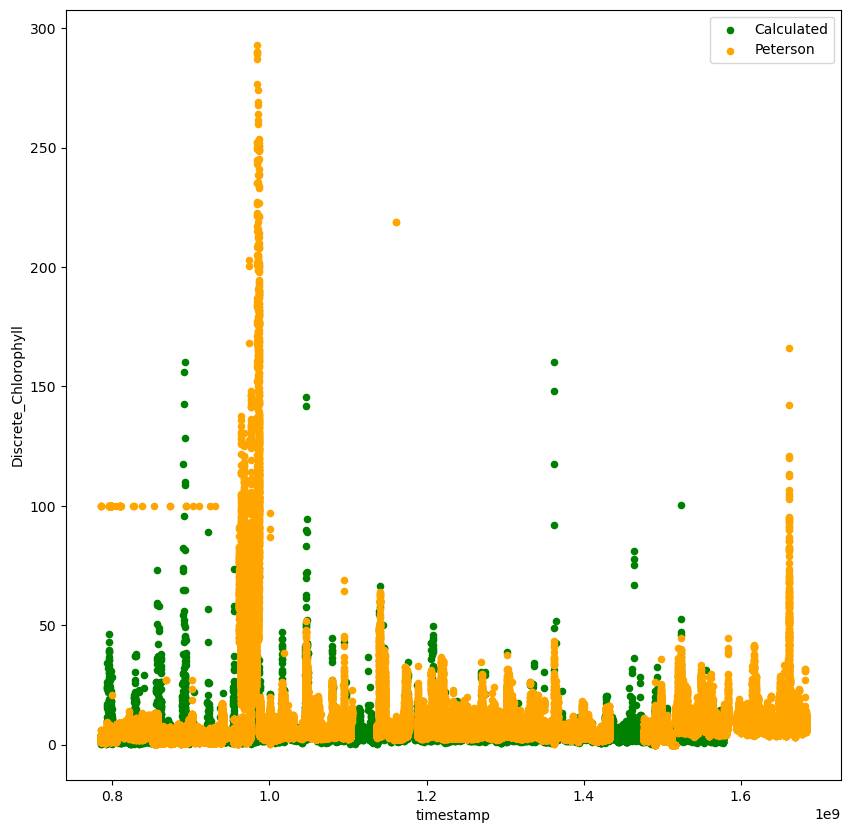

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
df_ft_plot = df_ft.sample(n=180000)
df_ft_plot = df_ft_plot[df_ft_plot.Discrete_Chlorophyll < 300]

df_wq.plot(ax=ax, x='timestamp', y='Calculated_Chlorophyll', c='green', kind='scatter', label='Calculated')
df_ft_plot.plot(ax=ax, x='timestamp', y='Discrete_Chlorophyll', c='orange', kind='scatter', label='Peterson')
plt.show()

## Visualization by reference line station

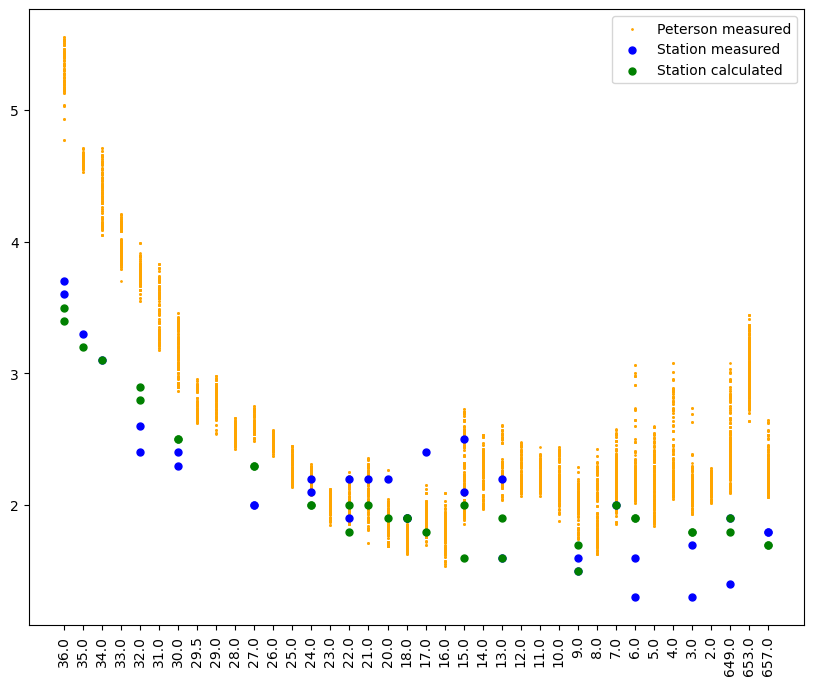

In [118]:
df_wq_vis = df_wq.copy()
df_ft_vis = df_ft.copy()

df_wq_vis = df_wq_vis[df_wq_vis.date == '2014-11-18']
df_ft_vis = df_ft_vis[df_ft_vis.datetime.dt.date == date(year=2014, month=11, day=18)]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(df_ft_vis['station_id'].astype(str), df_ft_vis['disc_chlor'], c='orange', label='Peterson measured', s=1)
ax.scatter(df_wq_vis['station_id'].astype(str), df_wq_vis['disc_chlor'], c='blue', label='Station measured', s=25)
ax.scatter(df_wq_vis['station_id'].astype(str), df_wq_vis['calc_chlor'], c='green', label='Station calculated', s=25)

plt.xlabel('Station')
plt.ylable('Chlorophyll')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Correlation Matrix

In [28]:
matrix = df_wq.corr(numeric_only=True)['Calculated_Chlorophyll']
peterson_matrix = df_ft.corr(numeric_only=True)['Discrete_Chlorophyll']
print(peterson_matrix)

lat                    -0.101225
lon                    -0.005771
depth                   0.021888
photic_depth           -0.113923
wind_spd                0.009652
wind_dir                0.045568
water_temp              0.002861
air_temp               -0.032956
bow_temp                0.000263
barometer               0.072220
Discrete_Chlorophyll    1.000000
turbidity               0.145162
suspended_part          0.121645
salinity                0.049773
fluor_switch            0.796075
new_lat                -0.102032
new_lon                -0.006120
dist_m                  0.020113
p_id                   -0.092355
d_from_start           -0.092784
d_from_station         -0.029386
station_id             -0.025902
timestamp              -0.051535
Name: Discrete_Chlorophyll, dtype: float64
2507.0


<Axes: xlabel='datetime', ylabel='Calculated_Chlorophyll'>

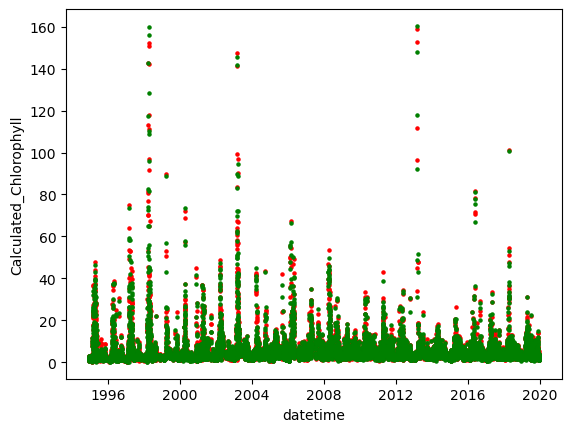

In [6]:
df_wq_plot = df_wq.dropna(subset=['Discrete_Chlorophyll', 'Calculated_Chlorophyll'])
#df_wq_plot = df_wq_plot[df_wq_plot.datetime.dt.year.between(2016, 2019)]

ax = df_wq_plot.plot('datetime', 'Discrete_Chlorophyll', kind='scatter', s=5, c='red')
df_wq_plot.plot(ax=ax, x='datetime', y='Calculated_Chlorophyll', kind='scatter', s=5, c='green')

## Method: k-NN Model
RSE = 0.45 @ k=2

[0.14516094112084815, 1.3768984761213248, 1.924236751799231, 2.40135031605711]


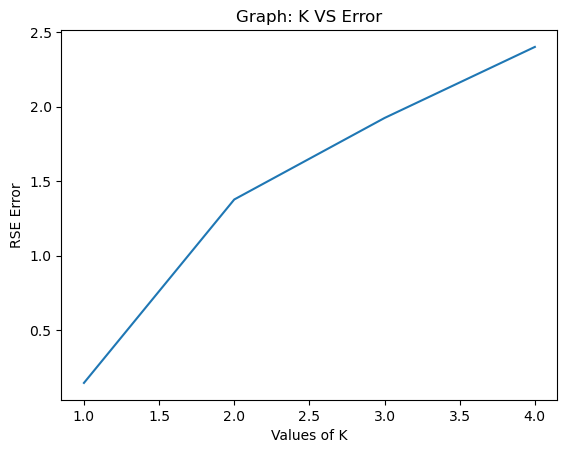

In [67]:
df_wq.dropna(subset=['timestamp', 'station_id', 'disc_chlor'], inplace=True)

X = df_wq[['timestamp', 'station_id', 'disc_chlor']]
y = df_wq['calc_chlor']

index = []
err = []
for i in range(1, 5):
    knn = KNeighborsRegressor(n_neighbors=i, n_jobs=8)
    knn.fit(X, y)
    y_pred = knn.predict(X)
    rss = sum((y_pred - y) ** 2)
    rse = math.sqrt(rss/(len(y)-2))
    index.append(i)
    err.append(rse)

print(err)
plt.plot(index, err)
plt.xlabel('Values of K')
plt.ylabel('RSE Error')
plt.title('Graph: K VS Error')
plt.show()

In [68]:
knn = KNeighborsRegressor(n_neighbors=1, n_jobs=8)
knn.fit(X.values, y.values)
test = df_ft[df_ft.station_id == 36].head(10)
test = test.drop(columns=['lat', 'lon', 'photic_depth'])
display(test.head())

x_pred = knn.predict(test[['timestamp', 'station_id', 'disc_chlor']])
print(x_pred)

,datetime,depth,wind_spd,wind_dir,water_temp,air_temp,bow_temp,barometer,disc_chlor,turbidity,...,file,datetime_out,new_lat,new_lon,dist_m,p_id,d_from_start,d_from_station,station_id,timestamp
402,1994-11-29 06:06:50,8.8,8.9,117.0,10.267,5.74,10.267,1025.4,1.1,0.010109,...,11290520.001,1994-11-29 06:06:50,37.475333,-122.072667,251.097050,121.0,1.458347,680.558667,36.0,786089210.0
403,1994-11-29 06:06:56,8.3,9.0,118.0,10.268,5.37,10.268,1025.4,1.1,0.010175,...,11290520.001,1994-11-29 06:06:56,37.475000,-122.072000,248.385354,118.0,1.385144,611.196580,36.0,786089216.0
404,1994-11-29 06:07:02,7.9,8.7,114.0,10.269,5.58,10.269,1025.4,1.1,0.010183,...,11290520.001,1994-11-29 06:07:02,37.475000,-122.072000,256.222798,118.0,1.385144,611.196580,36.0,786089222.0
405,1994-11-29 06:07:08,7.5,9.2,116.0,10.267,5.51,10.267,1025.7,1.1,0.010225,...,11290520.001,1994-11-29 06:07:08,37.474333,-122.070833,261.109352,112.0,1.253479,484.277596,36.0,786089228.0
406,1994-11-29 06:07:14,7.7,8.7,115.0,10.268,5.38,10.268,1025.7,1.1,0.010307,...,11290520.001,1994-11-29 06:07:14,37.474333,-122.070833,238.406847,112.0,1.253479,484.277596,36.0,786089234.0


[2.9 2.9 2.9 2.9 2.9 2.9 2.9 2.9 2.9 2.9]


c:\Users\ahernes\.conda\envs\PetersonFlowThrough\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


In [75]:
# Running model on reference line
df_ft_samp = df_ft[df_ft.file == '14322dat.txt']
df_ft_samp['knn_chlor'] = df_ft_samp.progress_apply(lambda x: knn.predict([[x.timestamp, x.station_id, x.disc_chlor]]), axis=1)


  0%|          | 0/8760 [00:00<?, ?it/s]

C:\Users\ahernes\AppData\Local\Temp\1\ipykernel_32192\292471551.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ft_samp['knn_chlor'] = df_ft_samp.progress_apply(lambda x: knn.predict([[x.timestamp, x.station_id, x.disc_chlor]]), axis=1)


In [80]:
df_ft_samp['knn_mean'] = round(((df_ft_samp.disc_chlor + df_ft_samp.knn_chlor) / 2), 3) 
df_ft_disp = df_ft_samp[['datetime', 'station_id', 'disc_chlor', 'knn_chlor', 'knn_mean']]
display(df_ft_disp.tail(50))

C:\Users\ahernes\AppData\Local\Temp\1\ipykernel_32192\1230901781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ft_samp['knn_mean'] = round(((df_ft_samp.disc_chlor + df_ft_samp.knn_chlor) / 2), 3)


,datetime,station_id,disc_chlor,knn_chlor,knn_mean
1921478,2014-11-18 18:25:42,657.0,2.19,[1.7],[1.9449999999999998]
1921479,2014-11-18 18:25:47,657.0,2.19,[1.7],[1.9449999999999998]
1921480,2014-11-18 18:25:52,657.0,2.19,[1.7],[1.9449999999999998]
1921481,2014-11-18 18:25:57,657.0,2.12,[1.7],[1.9100000000000001]
1921482,2014-11-18 18:26:02,657.0,2.12,[1.7],[1.9100000000000001]
1921483,2014-11-18 18:26:07,657.0,2.16,[1.7],[1.9300000000000002]
1921484,2014-11-18 18:26:12,657.0,2.16,[1.7],[1.9300000000000002]
1921485,2014-11-18 18:26:17,657.0,2.21,[1.7],[1.955]
1921486,2014-11-18 18:26:22,657.0,2.21,[1.7],[1.955]
1921487,2014-11-18 18:26:27,657.0,2.18,[1.7],[1.94]


## Method: SVR

In [25]:
X = df_wq[['timestamp', 'station_id', 'Discrete_Chlorophyll']]
y = df_wq['Calculated_Chlorophyll']

reg_svm = svm.SVR(cache_size=2000, max_iter=1000000)
reg_svm.fit(X, y)

test = df_ft[df_ft.station_id == 36].head(10)
test = test.drop(columns=['lat', 'lon', 'photic_depth'])
display(test.head())

x_pred = reg_svm.predict(test[['timestamp', 'station_id', 'Discrete_Chlorophyll']])
print(x_pred)

,datetime,depth,wind_spd,wind_dir,water_temp,air_temp,bow_temp,barometer,Discrete_Chlorophyll,turbidity,...,file,datetime_out,new_lat,new_lon,dist_m,p_id,d_from_start,d_from_station,station_id,timestamp
402,1994-11-29 06:06:50,8.8,8.9,117.0,10.267,5.74,10.267,1025.4,1.1,0.010109,...,11290520.001,1994-11-29 06:06:50,37.475333,-122.072667,251.097050,121.0,1.458347,680.558667,36.0,786089210.0
403,1994-11-29 06:06:56,8.3,9.0,118.0,10.268,5.37,10.268,1025.4,1.1,0.010175,...,11290520.001,1994-11-29 06:06:56,37.475000,-122.072000,248.385354,118.0,1.385144,611.196580,36.0,786089216.0
404,1994-11-29 06:07:02,7.9,8.7,114.0,10.269,5.58,10.269,1025.4,1.1,0.010183,...,11290520.001,1994-11-29 06:07:02,37.475000,-122.072000,256.222798,118.0,1.385144,611.196580,36.0,786089222.0
405,1994-11-29 06:07:08,7.5,9.2,116.0,10.267,5.51,10.267,1025.7,1.1,0.010225,...,11290520.001,1994-11-29 06:07:08,37.474333,-122.070833,261.109352,112.0,1.253479,484.277596,36.0,786089228.0
406,1994-11-29 06:07:14,7.7,8.7,115.0,10.268,5.38,10.268,1025.7,1.1,0.010307,...,11290520.001,1994-11-29 06:07:14,37.474333,-122.070833,238.406847,112.0,1.253479,484.277596,36.0,786089234.0


[2.29391516 2.2939152  2.29391525 2.29391529 2.29391534 2.29391538
 2.29391542 2.29391547 2.29391551 2.29391661]
